This notebook contains tests for the combined Prague map

In [104]:
import os
from glob import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from PIL import Image
import rioxarray as rxr
import rasterio as rio
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from io import BytesIO
import base64
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import branca
import pickle
import sys
sys.path.append("../src")
import maps as hw_maps

# Load Population

In [4]:
pop = gpd.read_file("../data/raw/prague_population_districts_meta2020.geojson")
pop.head(2)

,id,name,slug,updated_at,cze_general_2020,cze_men_2020,cze_women_2020,cze_elderly_60_plus_2020,cze_youth_15_24_2020,cze_children_under_five_2020,area (km²),pop_density_general,geometry
0,1,Praha-Řeporyje,praha-reporyje,None,12785,6185,6599,2892,1452,681,23.964755,533.491789,"POLYGON ((14.31810 49.98889, 14.31799 49.98921..."
1,2,Praha 1,praha-1,None,31518,15246,16272,7145,3576,1678,13.439654,2345.149640,"POLYGON ((14.41089 50.07867, 14.40982 50.07907..."


In [73]:
pop_figures = pop.loc[:, [c for c in pop.columns if c.startswith("cze")]+["name", "area (km²)"]]
pop_figures.set_index("name", inplace=True)
pop_figures.sort_values(by="cze_general_2020", ascending=True, inplace=True)

fig = px.bar(pop_figures.drop(["area (km²)", "cze_general_2020"], axis=1), 
             orientation="h",
             template="plotly_white",
             title="Total Population (p)")
fig.update_layout(yaxis_title="District",
                  xaxis_title="Total Population")
fig.show()

pop_density = (pop_figures.T / pop_figures["area (km²)"]).T

fig = px.bar(pop_density.drop(["area (km²)", "cze_general_2020"], axis=1),
             orientation="h",
             template="plotly_white",
             title="Population Density (p/km²)")
fig.update_layout(yaxis_title="District",
                  xaxis_title="Population Density")
fig.show()

In [122]:
pop_figures.sum()

cze_general_2020                1.348192e+06
cze_men_2020                    6.521620e+05
cze_women_2020                  6.960310e+05
cze_elderly_60_plus_2020        3.055230e+05
cze_youth_15_24_2020            1.529390e+05
cze_children_under_five_2020    7.183900e+04
area (km²)                      1.203044e+03
dtype: float64

In [127]:
pop_figures.sum(axis=0)

cze_general_2020                1.348192e+06
cze_men_2020                    6.521620e+05
cze_women_2020                  6.960310e+05
cze_elderly_60_plus_2020        3.055230e+05
cze_youth_15_24_2020            1.529390e+05
cze_children_under_five_2020    7.183900e+04
area (km²)                      1.203044e+03
dtype: float64

In [144]:
filtered_sum_df = round(pd.DataFrame(pop_figures.sample(40).sum().rename("Filtered")))
filtered_sum_df["Total"] = round(pop_figures.sum())
filtered_sum_df["Ratio"] = filtered_sum_df["Filtered"] / filtered_sum_df["Total"]
filtered_sum_df

,Filtered,Total,Ratio
cze_general_2020,949925.0,1348192.0,0.704592
cze_men_2020,459507.0,652162.0,0.704590
cze_women_2020,490415.0,696031.0,0.704588
cze_elderly_60_plus_2020,215250.0,305523.0,0.704530
cze_youth_15_24_2020,107761.0,152939.0,0.704601
cze_children_under_five_2020,50622.0,71839.0,0.704659
area (km²),792.0,1203.0,0.658354


In [38]:
pop.to_feather("../data/processed/prague_population_districts_meta2020.feather")

# Load LST

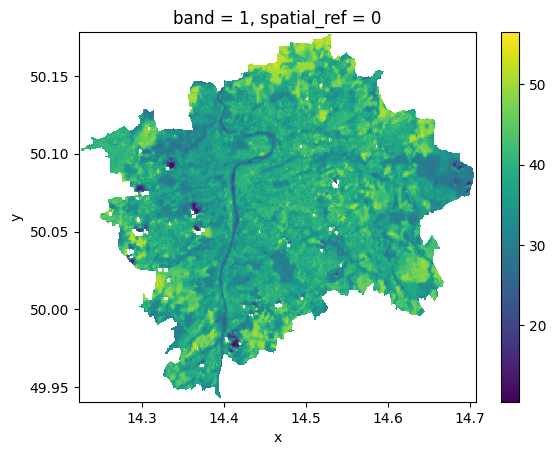

In [23]:
data_path = "../data/processed/Prague_LC08_L1TP_192025_20180817_20200831_02_T1/"
scene = [f for f in os.listdir(data_path)][0]
xds = rxr.open_rasterio(data_path + scene, masked=True)
xds.plot()

In [84]:
lst_dict = {}
for i, district in pop.iterrows():
        # Clip the TIFF data using the district's geometry
        clipped = xds.rio.clip([district.geometry], pop.crs, drop=True).squeeze()
        # Convert the clipped xarray Dataset to a DataFrame
        clipped_df = clipped.to_dataframe(name='lst').dropna().reset_index()
        lst_dict[i] = clipped

# Save the dictionary to a pickle file
with open('../data/processed/lst_dict.pkl', 'wb') as file:
    pickle.dump(lst_dict, file)

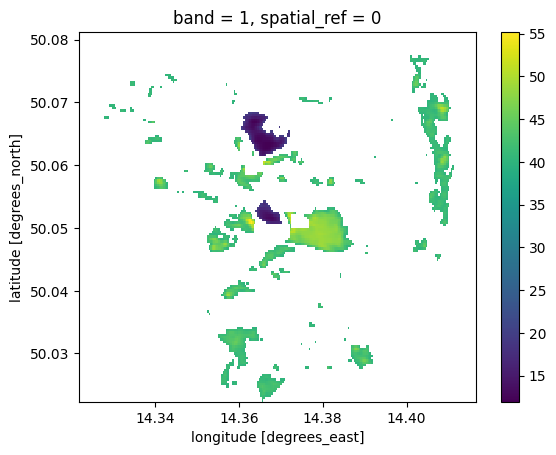

In [35]:
lst_test = lst_dict[i]
threshold = 30
lst_test.where((lst_test < 20) | (lst_test > 40)).plot()

In [88]:
def array_to_colored_png(data, cmap='jet', vmin=None, vmax=None, transparent=np.nan):
        if vmin is None:
            vmin = np.nanmin(data)
        if vmax is None:
            vmax = np.nanmax(data)

        # Normalize the data and apply the colormap
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        mapper = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        colored_data = mapper.to_rgba(data, bytes=True)  # Get RGBA data from the colormap

        # Set transparency for NaNs or data below a threshold
        if transparent is not None:
            alpha_channel = np.isnan(data) if np.isnan(transparent) else (data <= transparent)
            colored_data[..., 3] = np.where(alpha_channel, 0, 255)  # Update alpha channel: 0 is transparent, 255 is opaque

        # Convert array to an image
        img = Image.fromarray(colored_data)
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='PNG')
        img_byte_arr = img_byte_arr.getvalue()
        
        # Convert to base64 and create data URL
        base64_encoded = base64.b64encode(img_byte_arr)
        base64_data_url = f"data:image/png;base64,{base64_encoded.decode()}"

        return base64_data_url


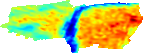
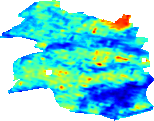
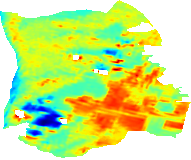
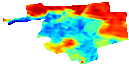

In [106]:
m = folium.Map()
 
for key in [1, 3, 4, 6]:
    this_lst = lst_dict[key]
    img_bytes = array_to_colored_png(this_lst)
    left, bottom, right, top = this_lst.rio.bounds()

    # Create an image overlay
    img_overlay = folium.raster_layers.ImageOverlay(
        img_bytes,
        bounds=[[bottom, left], [top, right]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
        name="Land Surface Temperature 10:00, 17.08.2018"
    )
    img_overlay.add_to(m)

colorbar = hw_maps.generate_colorbar(data=this_lst)

m.fit_bounds(m.get_bounds())
colorbar.add_to(m)
m

In [ ]:

def add_raster_to_map(lst_path, m):
    with rio.open(lst_path) as src:
        image_bounds = src.bounds
        data = src.read(1)
    
    img_bytes = array_to_colored_png(data)
    left, bottom, right, top = image_bounds

    # Create an image overlay
    img_overlay = folium.raster_layers.ImageOverlay(
        img_bytes,
        bounds=[[bottom, left], [top, right]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
        name="Land Surface Temperature 10:00, 17.08.2018"
    )
    img_overlay.add_to(m)

    # Create Colorbar
    colorbar = generate_colorbar(data=data)
    colorbar.add_to(m)
    return m

In [36]:
masked_lst = np.ma.masked_outside(lst_test, 20, 40)
lst_with_nan = masked_lst.filled(np.nan)
lst_with_nan.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'